# Linear Regression Notes

**These notes rely on a variety of sources:**
- [Chapters 1-2 of Shalizi's book](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/ADAfaEPoV.pdf)
- [Atri's slides from 440](http://www-student.cse.buffalo.edu/~atri/algo-and-society/support/notes/models/index.html)
- [Varun's prior notes from this class](https://mlcourse-ub.readthedocs.io/en/latest/docs.html)

In [195]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)


# A Motivating Example

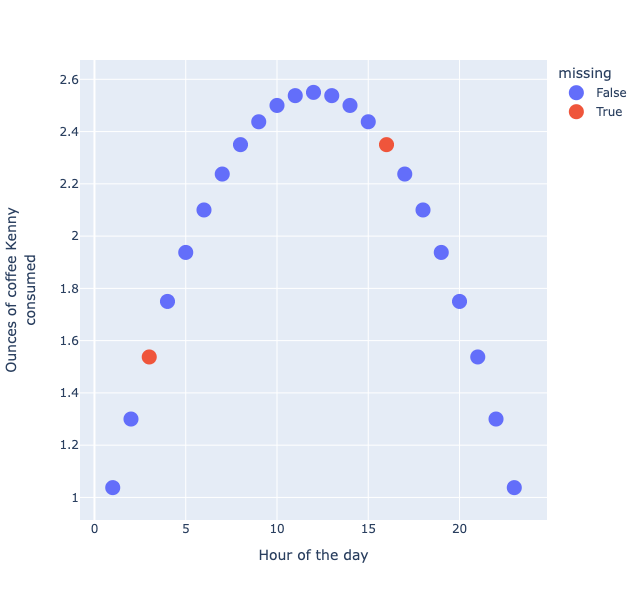

In [237]:

np.random.seed(seed=25)
data = pd.DataFrame([(x, (-.5*(x**2)+12*x+30)/40) 
                     for x in range(1,24)], 
                    columns= ['x','y'])
data['y'] = data['y'] #+ norm(0,.1).rvs(len(data))
missing_data = [False] * len(data)

missing_data[2] = True
missing_data[15] = True
data = data.assign(missing = missing_data)
fig = px.scatter(data, x="x",y='y', 
           labels = {"x" : "Hour of the day", 
                     "y" : "Ounces of coffee Kenny<br>consumed"},
           color="missing",
          height=600, width=800)
fig.update_traces(marker={'size': 15})
fig.show()

## Necessary thought exercise #1

- What is your best guess for the value of me making a free throw for $x=3$ (3am)? 
- What about for $x=16$ (4pm)? 
- **How would you figure that out?**

### Why is this exercise necessary?
In Machine Learning, we ask the question of "how would you figure this out" via a **three step process**:

1. We define a **model class** (or synonymously, a **hypotheses class**). We will pick one of those to be our predictive model.
2. We define a **loss function**. This defines the "best" model, i.e. the one we're going to pick.
3. We define an **optimization algorithm**. This is *how we actually find the best model*.


### Digging deeper... Model Class

A **model class**, or **hypothesis class**, sometimes represented as $\mathcal{H}$, is the set of all possible functions that we could possibly learn, and select for our final model.

Some desireable properties of a model class:
- **Parsimonious representation**: We would like our model class to have its representation size not depend on the size of the dataset. In addition, models with small representation size can be considered to be the "right" model... we'll talk about this later on in class.
- **Efficient training**: We have to actually be able to find the best model.
- **Efficient prediction**: We don't want to have to wait forever for our model to make predictions!
- **Model expressivity**: In other words, for "real life" data, how accurately can this model class predict the correct labels?

### Digging deeper... Loss function

From [Weinberger's ML course](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote01_MLsetup.html):

> We try to find a function $h$ within the hypothesis class that makes the fewest mistakes within our training data... How can we find the best function? For this we need some way to evaluate what it means for one function to be better than another. This is where the loss function (aka risk function) comes in. A loss function evaluates a hypothesis $h \in \mathcal{H}$ on our training data and tells us how bad it is. The higher the loss, the worse it is - a loss of zero means it makes perfect predictions. 

Let's call our loss function (for a given hypothesis) $\mathcal{L}(h)$.

### Digging deeper ... Optimization Algorithm

Our goal now is just to find $h^* \in \mathcal{H}$ such that:

$$h^* = \mathop{\mathrm{argmin}}_{h \in \mathcal{H}} \mathcal{L}(h)$$

# Motivating Linear Regression

One way to motivate/understand (ordinary least squares) linear regression is that it defines a specific model class, with a specific loss function, and has a closed-form approach to optimization. However, I'm going to take a slightly different motivating approach first, and then circle back to this.


## Necessary thought exercise #2

OK, now... **what if you could only make 1 guess for both of them?**


### The "Predict Only One" Best Answer

**This section largely follows [Shalizi, Chapter 1](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/ADAfaEPoV.pdf)**

As we saw above, to say one model is "better" than another, we need some notion of "better". For reasons that will become clear as we move through this course, a typical notion of "better" is the **mean squared error (MSE)**. For a true value $y$ and a predicted value $\hat{y}$, the MSE of the prediction is:
$$MSE(\hat{y}) = (y-\hat{y})^2$$

**Exercises**: 
- Why do we square this?
- What other things could you think to do instead?

Now, let's assume we're trying to predict the value of some random variable $Y$, and our goal is to make the best single prediction for it. Let's use MSE as our error metric.  Because $Y$ is a random variable, we cannot specify an exact value for this MSE. Instead, we have to think about the *expectation* of that MSE. Let's keep $\beta$ as our prediction. Then our goal is to find the best possible value of $\beta$; let's call (that best possible) value $\beta^*$.  Put formally, we want to solve the following optimization problem:

$$\beta^* = \mathop{\mathrm{argmin}}_{\beta \in \mathcal{R}} MSE(\beta) =  \mathop{\mathrm{argmin}}_{\beta \in \mathcal{R}} \mathbb{E}\left[(Y -\beta )^2\right]$$

With some fancy manipulations (see Shalizi), we get that

$$MSE(\beta) = (\mathbb{E}[Y] - \beta)^2 + \mathrm{Var}[Y]$$

Now, we want to find the optimal value for $\beta$. Notice that the second term doesn't depend on our prediction, so we don't need to worry about it during optimization.  So now, we want to find:

$$ \beta^* = \mathop{\mathrm{argmin}}_{\beta \in \mathcal{R}} \, (\mathbb{E}[Y] - \beta)^2$$

The solution to this is $\beta^* = \mathbb{E}[Y]$; that is, the best prediction to make is the expected value of the random variable!

**Excercises**
- Why does this result follow from the math above? *Hint: Calculus is your friend here*
- (Don't peek below ...) What does this mean about how we should estimate the value of $\beta$ from data?

### "Predict Only One" When you only have a sample

The above tells us what to do when we know $\mathbb{E}[Y]$. Sadly, to know that, we would need all of the data from the population. What to do? Well, our friend the *law of large numbers* tells us that if we have iid samples $y_1,...y_n$ from the population, then our sample mean---let's call that $\hat{\mu}$, converges to $\mathbb{E}[Y]$! So even those we don't *know* $\mathbb{E}[Y]$, we have something that converges to it as $n$ increases.

So, our "predict only one" *optimal answer* is the sample mean. Let's see what that looks like with our data from above!

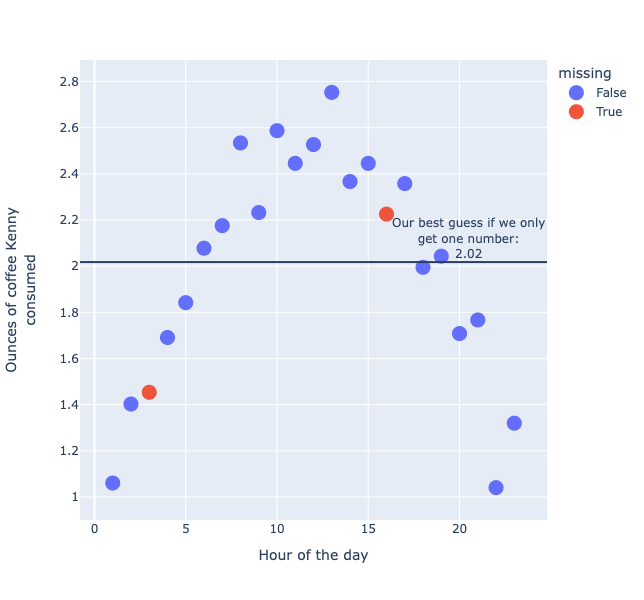

In [225]:
# Compute sample mean (ignoring the "missing data")
sample_mean = data[~data.missing].y.mean()


# Plot the sample mean along with the figure
fig.add_hline(y=sample_mean, 
    annotation_text=f"Our best guess if we only<br>get one number:<br>{sample_mean:.2f}")
fig.show()

## How good of a guess is that?

**Exercise (don't peek!)**: How would *you* evaluate how good of a guess this is for the two missing data points?

We'll return to how I would do it in a bit.

# The Regression Function

In the meantime, let's look at the more interesting case. To this point, we've totally ignored the information that we have on the x-axis; i.e., what attempt number it is for me.  Clearly, there is some valuable information there!

Put another way, if instead of just making a prediction based on our samples $y_1,...y_n$, we *also* used information from our $x_1,...,x_n$s, we should be able to make better predictions.  

Put yet another way, then, we want our predictions to *be a function of the $X$s!*. Let's call that function $f(X)$. 

Now we can again ask, what should the function be to minimize our MSE? In other words, what should we set $f$ as to minimize $MSE(f)$?

In the notation from above, we want to solve:

$$\mu(x) = \mathop{\mathrm{argmin}}_{f} MSE(f(X)) =  \mathop{\mathrm{argmin}}_{f} \mathbb{E}\left[\left(Y - f(X)\right)^2\right]$$

With similar math as above (see Shalizi, 1.12-1.15 if you want to do it out yourself), we get that:

$$ \mu(x) = \mathbb{E}[Y | X = x] $$

That is, the optimal prediction in terms of MSE for $Y$ when we have information about $X$ is to take the *conditional expected value* at that value of $x$. This equation abouve is called the **regression function**.



# Now what?

Let's come back to our machine learning perspective, now. When we say we want to define a model/hypothesis class, we can now say precisely what we are doing:

- We are building a model/hypothesis class *for the regression function*. 
- The regression function, in turn, makes an assumption that our *loss function is MSE*

What model class might we choose that optimizes for our goals above---parsimony, efficient training, efficient prediction, and model expressivity?  The most common answer to this question for a very long time in both statistics and machine learning has been a **linear model**. In a **linear model**, we *choose* to approximate $\mu(x)$ with a function that is linear in the model parameters. 

In the case where $x$ is a single variable, then, we approximate $\mu(x)$ with the function $b_0 + b_1x$. 

**Exercise:** Why don't we just use $b_1x$ as the approximation?


# Returning to our simple example

Neat! Let's run a linear regression


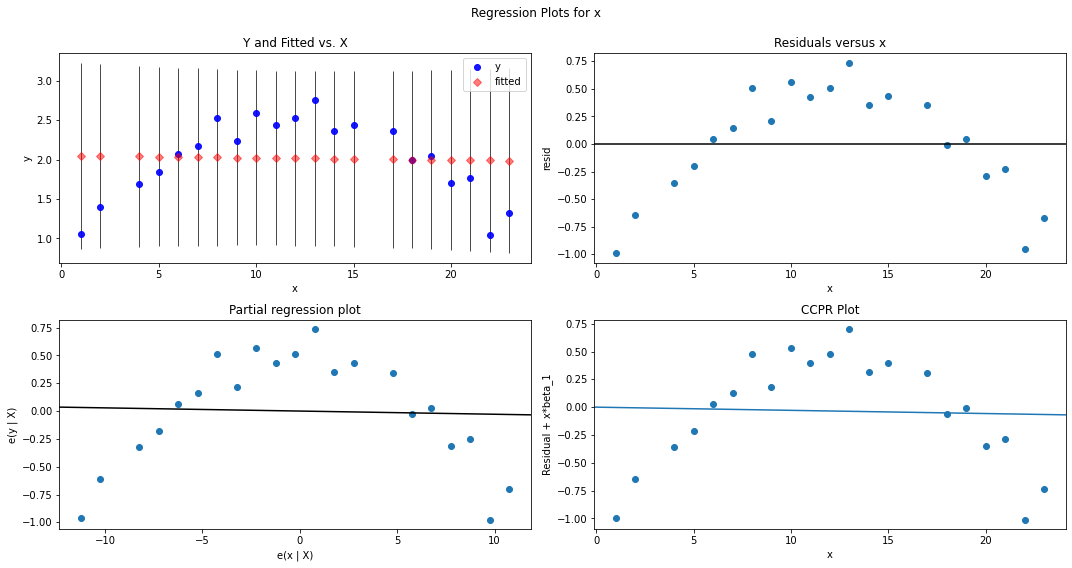

In [226]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

f = 'y~x'
model = ols(formula=f, data=data[~data.missing]).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'x', fig=fig)

## Making and evaluating predictions

In [227]:
model.predict(data[data.missing])

2     2.044102
15    2.006815
dtype: float64

**Uh. Not so good. What if we make the task a little less trivial?**

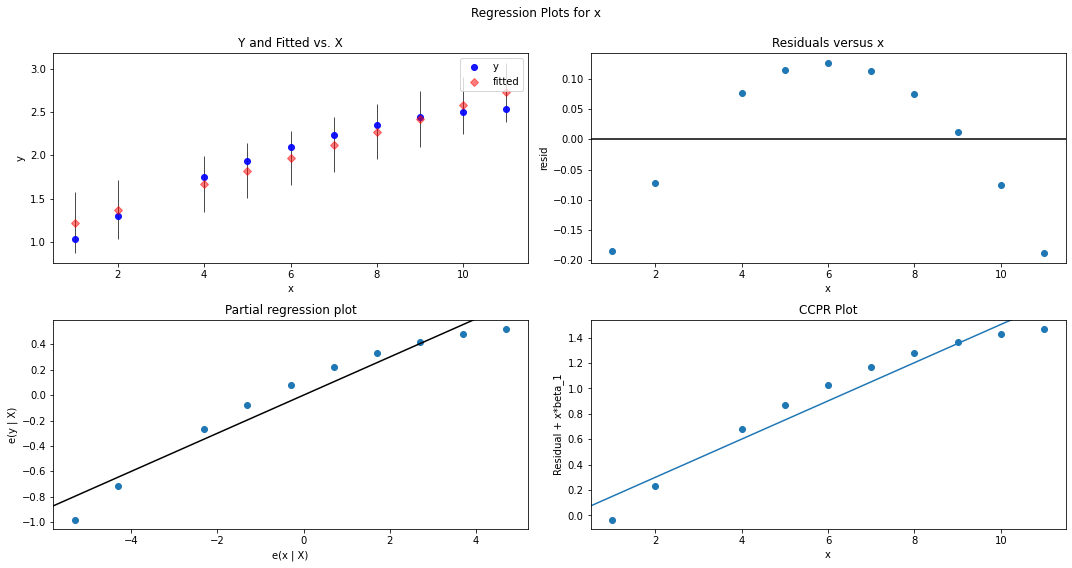

In [238]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

f = 'y~x'
model = ols(formula=f, data=data[(~data.missing)&(data.x < 12)]).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'x', fig=fig)

In [229]:
model.predict(data[data.x == 2]), data[data.x ==2].y

(1    1.387687
 dtype: float64,
 1    1.402689
 Name: y, dtype: float64)

In [230]:
model.summary()

/Users/kjoseph/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     75.84
Date:                Mon, 07 Feb 2022   Prob (F-statistic):           2.36e-05
Time:                        15:10:10   Log-Likelihood:                 4.9532
No. Observations:                  10   AIC:                            -5.906
Df Residuals:                       8   BIC:                            -5.301
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1007      0.116      9.475      0.000       0.833       1.369
x              0.1435      0.016      8.709      0.000       0.106       0.181
==============================================================================
Omnibus:                        0.055   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.973   Jarque-Bera (JB):                0.131
Skew:                           0.068   Prob(JB):                        0.936
Kurtosis:                       2.455   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

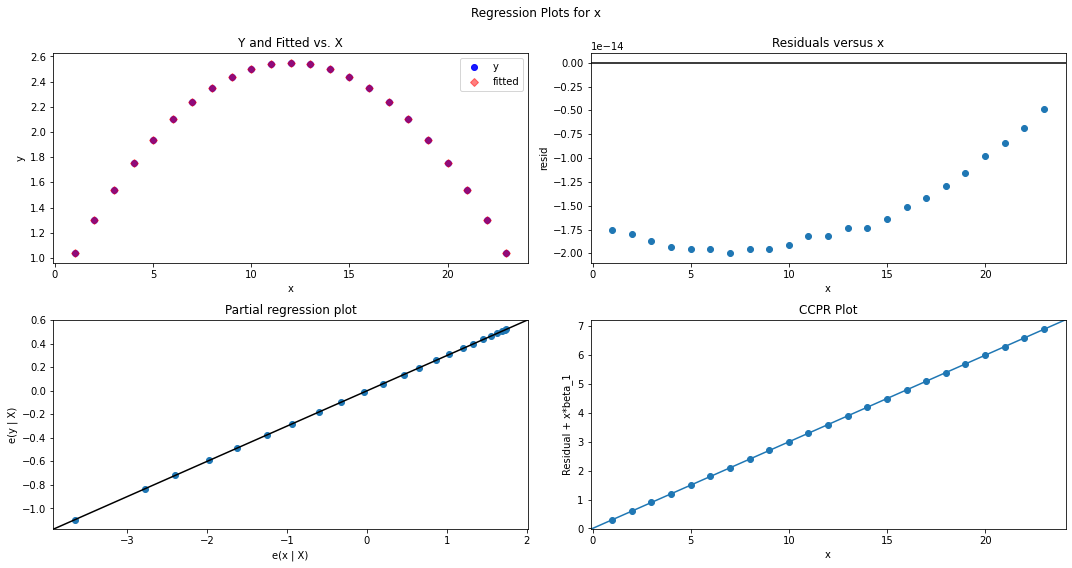

In [239]:
data['x_sq'] = data['x'].pow(2)
f = 'y~x+x_sq'
model = ols(formula=f, data=data).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'x', fig=fig)

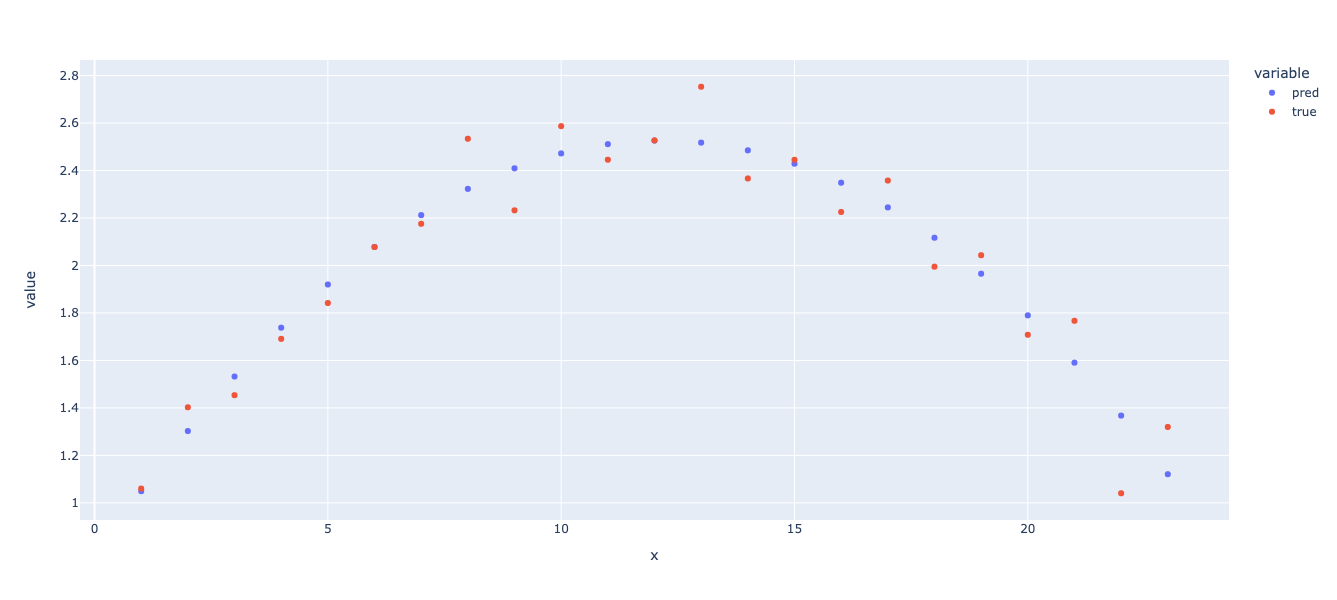

In [236]:
results = pd.DataFrame(zip(model.predict(data),data.y,data.x), columns=['pred','true','x'])
px.scatter(pd.melt(results,id_vars="x"), 
           x="x",y="value",color="variable",
          height=600,width=700)

# A pre-Real world Real world example

### California Housing Data

https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

- ```MedInc``` median income in block group
- ```HouseAge``` median house age in block group
- ```AveRooms``` average number of rooms per household
- ```AveBedrms``` average number of bedrooms per household
- ```Population``` block group population
- ```AveOccup``` average number of household members
- ```Latitude``` block group latitude
- ```Longitude``` block group longitude

In [159]:
from sklearn.datasets import fetch_california_housing
boston_data = fetch_california_housing()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)
df_boston.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Fitting a linear regression model on Boston data set
Which features to use?

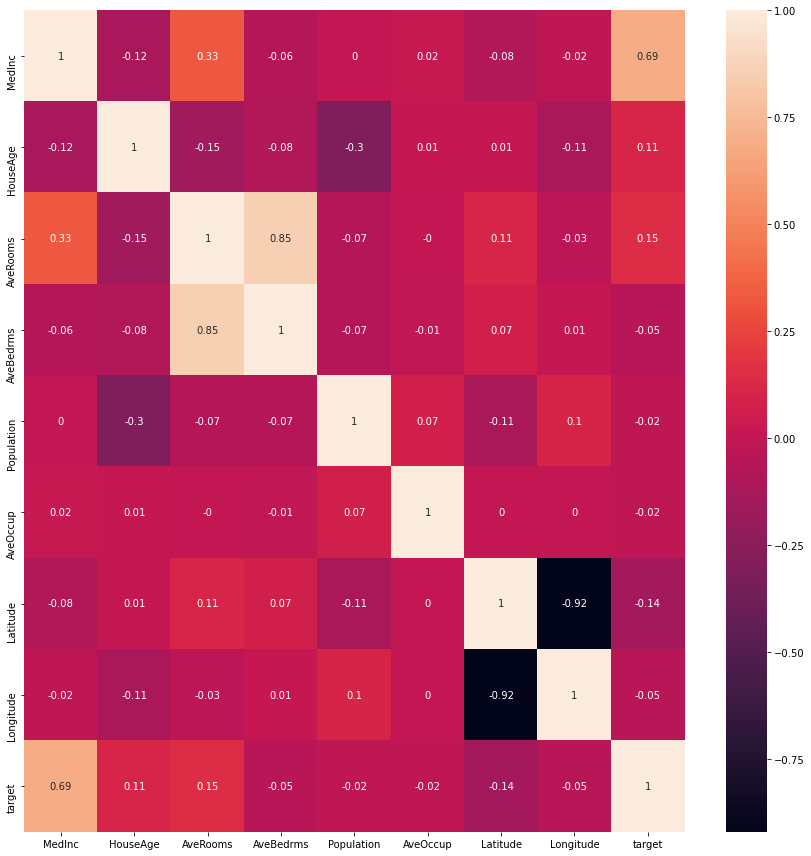

In [161]:
import seaborn as sns
correlation_matrix = df_boston.corr().round(2)
# annot = True to print the values inside the square
fig = plt.figure(figsize=(12,12))
ax = sns.heatmap(data=correlation_matrix, annot=True)
plt.tight_layout()

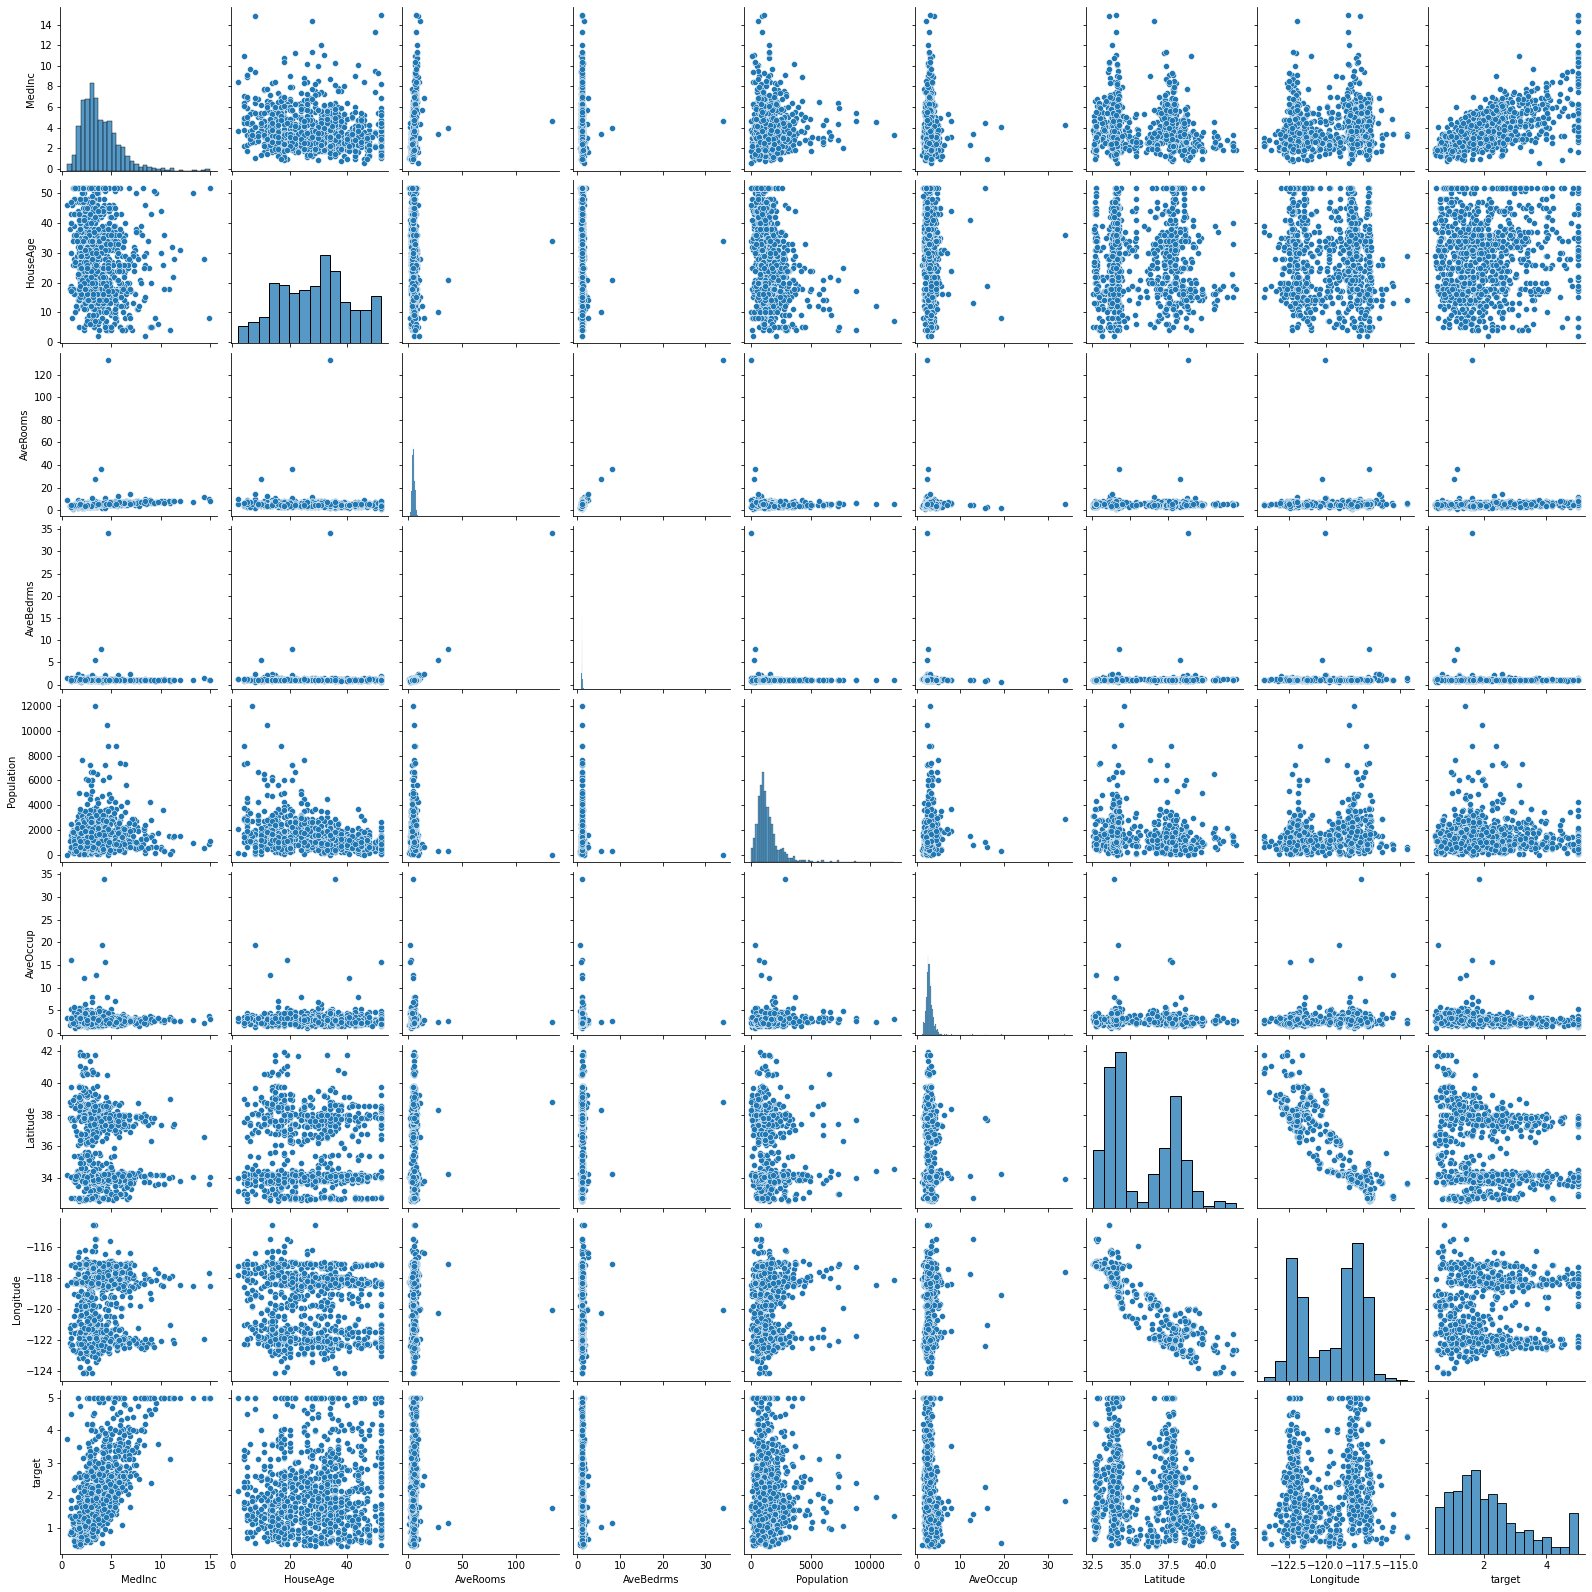

In [163]:
sns.pairplot(df_boston.sample(1000), vars = df_boston.columns)

Generally, you might be tempted to use features that are strongly correlated with the target (correlation closer to +1 or -1), e.g., LSTAT, RM. For linear regression, that might be the case, however, linear correlation is not the only indicator. You could have combinations of seemingly uncorrelated features that could yield a good prediction for the target.

In [165]:
from sklearn.linear_model import LinearRegression
X = df_boston[df_boston.columns[:-1]]
y = df_boston['target']

lmodel = LinearRegression(normalize=True)
lmodel.fit(X,y)

LinearRegression(normalize=True)

In [166]:
lmodel.coef_

array([ 4.36693293e-01,  9.43577803e-03, -1.07322041e-01,  6.45065694e-01,
       -3.97638942e-06, -3.78654265e-03, -4.21314378e-01, -4.34513755e-01])

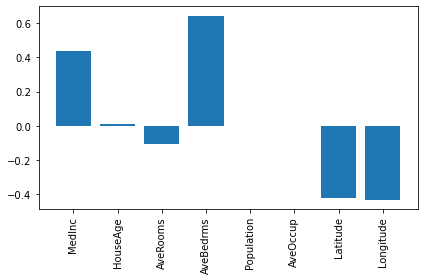

In [167]:
plt.bar(df_boston.columns[:-1],lmodel.coef_)
plt.xticks(rotation='vertical')
plt.tight_layout()

In [168]:
lmodel.intercept_

-36.94192020718432

#### Importance of intercept
What happens if out model did not have an intercept, i.e., we are forcing the hyper-plane to go through the origin?

We are going to check if having an intercept impacts the accuracy of the model. This is where we introduce the notion of training error vs. generalization error.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [172]:
from sklearn.metrics import mean_squared_error
lmodel = LinearRegression()
lmodel.fit(X_train,y_train)

y_test_predicted = lmodel.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predicted)))
print('RMSE on testing data with intercept is {}'.format(rmse))

RMSE on testing data with intercept is 0.7323542382277799


In [173]:
lmodel = LinearRegression(fit_intercept=False)
lmodel.fit(X_train,y_train)

y_test_predicted = lmodel.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predicted)))
print('RMSE on testing data without intercept is {}'.format(rmse))

RMSE on testing data without intercept is 0.7852840155633771


Having no intercept makes the model less accurate


**Side point ... what's the deal with the whole ```train_test_split``` thing? We'll return to this later...**

# OK!

So we've seen the basics of linear regression.  There are, however, a few things that we have yet to do:

- Return to our original real world example (pending time, let's do that today)
- **Learn how to optimize a linear regression** ... we'll see this Thursday!